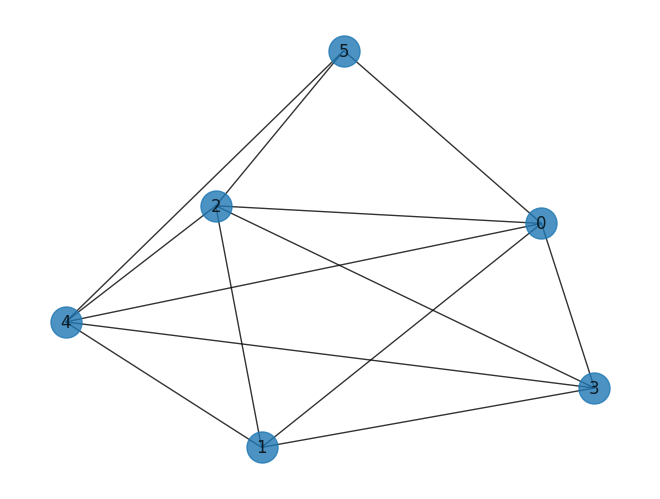

In [6]:
import networkx as nx
graph = nx.Graph()
graph.add_nodes_from([0, 1, 2, 3, 4, 5])
graph.add_weighted_edges_from([(0, 1, 2), (1, 2, 2), (2, 3, 2), (3, 4, 2), (4, 0, 2), (0, 5, 4), (5, 2, 4), (5, 4, 1), (0,2,3), (2,4,3), (4,1,3), (1,3,3), (3,0,3)])
nx.draw(graph, with_labels=True, alpha=0.8, node_size=500)

In [14]:
from qiskit import QuantumCircuit, Aer
from qiskit.circuit import Parameter

def TSP_obj(solution, graph):
    obj = 0
    num_nodes = len(solution)
    i = 0
    j = 0

    for i in range(graph.nodes):
        note = 0
        for j in range(len(set(graph.edges))):
            note += solution[i][j]
        obj += note

    if len(set(solution)) != num_nodes:
        return float('inf')

    for i in range(num_nodes - 1):
        obj += graph[solution[i]][solution[i+1]]['weight']
    
    obj += graph[solution[num_nodes-1]][solution[0]]['weight']
    return obj


In [8]:
def compute_expectation(counts, graph):
    avg = 0
    sum_count = 0
    for bit_string, count in counts.items():
        obj = TSP_obj(bit_string, graph)
        avg = obj * count
        sum_count += count
    return avg/sum_count

In [17]:
def create_qaoa_circ(graph, theta):
    nqubits = len(graph.nodes())**2
    n_layers = len(theta)//2
    beta = theta[:n_layers]
    gamma = theta[n_layers:]

    qc = QuantumCircuit(nqubits)
    qc.h(range(nqubits))

    for layer_index in range(n_layers):
        
        for pair in list(graph.edges()):
            qc.rzz(gamma[layer_index], pair[0], pair[1])

        for qubit in range(nqubits):
            qc.rx(beta[layer_index], qubit)

    qc.measure_all()
    return qc

In [21]:
def get_expectation(graph, shots=512):
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots

    def execute_circ(theta):
        qc = create_qaoa_circ(graph, theta)
        counts = backend.run(qc, seed_simulator=10,
                                nshots=512).result().get_counts()
        print(theta)
        return compute_expectation(counts, graph)
    return execute_circ

In [25]:
from scipy.optimize import minimize
expectation = get_expectation(graph)
res = minimize(expectation,
               [1.0, 1.0],
               method='COBYLA')
res

CircuitError: 'Index 1 out of range for size 1.'